# NYC 311 Dataset

Boroughs - location of incidents
- 5 Boroughs in NYC
- Manhattan, Brooklyn, Queens, Bronx, Staten Island
- There are some unspecified locations of incidents in the dataset
- Where the incident physically occurred.

Agencies - the city department responsible for resolving the incident
- All part of NYC government 
- Completely separate departments with their own funding, staffing, operational procedures, areas of responsibility, and service level expectations

- 311 categorizes and routes to a correct agency

### NYC 311 Agencies

1. NYPD (New York City Police Department)
- General Role: Public safety, law enforcement, quality-of-life enforcement
- 311 responsibilities include: noise complaints, illegal parking, blocked driveways, graffiti, public drinking, disorderly conduct, traffic enforcement complaints, homeless encampments

2. HPD (Housing Preservation and Development)
- General Role: Protecting residential housing quality and enforcing housing codes
- 311 responsibilities include: no heat / no hot water, plumbing leaks, mold/mildew, rodents and pests inside dwellings, broken locks/doors/windows, illegal landlord behavior or property neglect, building-wide maintenance issues

3. DSNY (Department of Sanitation)
- General Role: Waste management and cleanliness
- 311 responsibilities include: missed garbage collection, improper disposal, overflowing trash bins, illegal dumping, dirty sidewalks or streets, dead animal removal, recycling issues

4. DOT (Department of Transportation)
- General Role: Street, traffic, and public roadway infrastructure management
- 311 responsibilities include: potholes, broken or missing street signs, damaged traffic signals, streetlight outages, sidewalk damage, wrong way signs/visibility issues

5. DEP (Department of Environmental Protection)
- General Role: Water, air, sewer, and environmental quality
- 311 responsibilities include: water main breaks, sewer backups, water discoloration/water quality issues, construction noise, air quality complaints, industrial fumes, water pressure issues

6. DOB (Department of Buildings)
- General Role: Building construction safety, code enforcement, and permits
- 311 responsibilities include: unsafe building conditions, illegal construction, structural concerns, scaffolding issues, elevators out of service, failure to maintain fire escapes

7. DPR (Department of Parks & Recreation)
- General Role: Public parks, trees, recreational facilities
- 311 responsibilities include: Dead tree/tree limb removal, damaged playground equipment, park maintenance issues, overgrown trees damaging property, public pool or recreation center issues

8. DOHMH (Department of Health and Mental Hygiene)
- General Role: Public health regulation and disease prevention
- 311 responsibilities include: rodents in public spaces, restaurant sanitary complaints, public health hazards, standing water, smoking complaints, hazardous materials

9. DHS (Department of Homeless Services)
- General Role: Homeless outreach, shelters, social services
- 311 responsibilities include: homeless encampment reports, people in need of social services, issues at shelters, quality-of-life concerns involving homeless individuals

10. DCWP (Department of Consumer and Worker Protection)
- General Role: Consumer rights, business regulation, workplace fairness
- 311 responsibilities include: price gouging, business licensing issues, consumer fraud, employment law violations, scams, predatory business practices

11. TLC (Taxi and Limousine Commission)
- General Role: Regulation of taxis, Ubers, Lyfts, for-hire vehicles
- 311 responsibilities include: unsafe taxi/Uber driving, fare disputes, taxi refusal, overcharging, dirty or unsafe vehicles, illegal for-hire activity

12. DOE (Department of Education)
- General Role: School facilities, maintenance, and safety
- 311 responsibilities include: school building heating issues, school cleanliness, school food safety, leaks/pests/facility requests

13. OTI (Office of Technology and Innovation)
- General Role: Citywide IT infrastructure
- 311 responsibilities include: website outages, city system technical problems, 311 app issues, access problems for digital services

14. OOS (Office of Operations (Mayor’s Office))
- General Role: Cross-agency operations, oversight, and coordination
- 311 responsibilities include: oversight-level complaints, issues requiring escalation, administrative or inter-agency matters

15. EDC (Economic Development Corporation)
- General Role: Economic growth, waterfront management, industrial support
- 311 responsibilities include: some waterfront complaints, business district issues, public-private development maintenance concerns

## The purpose of NYC 311 dataset

### 1. Operational decision-making
Identify which problems occur most often, when, and where, so the city can deploy staff more efficiently.
- incident numbers by boroughts/agencies 
 - incidents per capita per borough
 - agency load imbalance? 
- prediction of likelihood of each type of incidents by boroughs based on the frequencies of each type as well as by seasonal (is this enough with one year's data?)

### 2. Trend detection
Understand long-term patterns (seasonality, rising complaints, emerging issues).
- how to avg resolution time for incidents generally trend over weeks/months as well as for each incident type
- is seasonality predictable? Perhaps with 5 boroughs and multiple agencies it may yield a credible result
- emerging issues shown by trend of number of each type of incident

“With one year of data, we can identify intra-year seasonality (winter heat complaints, summer noise spikes, etc.). Multi-year trend detection is possible if we expand this project later.”

improvements - use moving averages to smooth trends, use year-over-year comparison is additional years are added later

### 3. Service performance evaluation
Measure how long different agencies take to resolve complaints.
- median/mean resolution time per agency
- median/mean resolution time per complaint type
- different in resolution speed across boroughs
- use distributions, not only averages
 - resolution time often have long right tails - extreme delays

### 4. Resource allocation
Decide which boroughs or agencies need more staffing or funding.
- depends on resolution time and number of incidents. analysis provided above

### 5. Predictive modeling (research + analytics)
Predict future incident volumes or resolution times to improve service planning.
- overall (with the whole dataset)
- by boroughs
- by agencies

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

plt.rcParams["figure.figsize"] = (10, 5)

BASE_DIR = Path.cwd().parents[0]  # notebooks/ -> project root
CLEAN_PATH = BASE_DIR / "data" / "cleaned" / "nyc_311_full_year_cleaned.parquet"

df = pd.read_parquet(CLEAN_PATH)
df.shape

(3207336, 14)

In [89]:
df.head(10)

,created_date,closed_date,complaint_type,descriptor,agency,borough,incident_zip,latitude,longitude,resolution_hours,month,hour,weekday,is_weekend
0,2024-12-27 05:01:12,2024-12-27 09:04:50,Illegal Parking,Blocked Hydrant,NYPD,QUEENS,11417,40.67604759711457,-73.83285041094713,4.060555,12.0,5.0,4.0,0.0
1,2024-12-27 05:03:45,2024-12-27 11:41:50,Blocked Driveway,No Access,NYPD,BRONX,10466,40.88614032903141,-73.85260382773865,6.634722,12.0,5.0,4.0,0.0
2,2024-12-27 05:03:51,2024-12-31 15:38:47,HEAT/HOT WATER,ENTIRE BUILDING,HPD,QUEENS,11377,40.74133262269033,-73.92076399754987,106.582222,12.0,5.0,4.0,0.0
3,2024-12-27 05:04:10,2024-12-27 08:51:28,HEAT/HOT WATER,ENTIRE BUILDING,HPD,BRONX,10458,40.871162633641255,-73.88671175432482,3.788333,12.0,5.0,4.0,0.0
4,2024-12-27 05:07:03,2024-12-27 05:07:03,Building/Use,Illegal. Commercial Use In Resident Zone,DOB,BROOKLYN,11208,40.673488433040575,-73.86095438129898,0.000000,12.0,5.0,4.0,0.0
5,2024-12-27 05:07:46,2024-12-29 18:12:55,HEAT/HOT WATER,ENTIRE BUILDING,HPD,BROOKLYN,11225,40.66515315606502,-73.95373536849284,61.085835,12.0,5.0,4.0,0.0
6,2024-12-27 05:08:04,2024-12-27 06:45:54,Blocked Driveway,No Access,NYPD,QUEENS,11354,40.769700037591605,-73.8280267519398,1.630556,12.0,5.0,4.0,0.0
7,2024-12-27 05:09:19,2024-12-27 05:32:29,Illegal Parking,Blocked Hydrant,NYPD,QUEENS,11385,40.70550471181509,-73.88717722773042,0.386111,12.0,5.0,4.0,0.0
8,2024-12-27 05:10:01,2024-12-27 05:38:32,Noise - Residential,Loud Music/Party,NYPD,BROOKLYN,11212,40.657992266567,-73.90170315092821,0.475278,12.0,5.0,4.0,0.0
9,2024-12-27 05:10:38,2024-12-30 20:29:53,HEAT/HOT WATER,APARTMENT ONLY,HPD,QUEENS,11419,40.68500126275528,-73.82924755935618,87.320831,12.0,5.0,4.0,0.0


In [90]:
# Remove df[latitude] and df[longitude] as they are not needed for modeling
df2 = df.drop(columns=["latitude", "longitude"])
df2.head(10)

,created_date,closed_date,complaint_type,descriptor,agency,borough,incident_zip,resolution_hours,month,hour,weekday,is_weekend
0,2024-12-27 05:01:12,2024-12-27 09:04:50,Illegal Parking,Blocked Hydrant,NYPD,QUEENS,11417,4.060555,12.0,5.0,4.0,0.0
1,2024-12-27 05:03:45,2024-12-27 11:41:50,Blocked Driveway,No Access,NYPD,BRONX,10466,6.634722,12.0,5.0,4.0,0.0
2,2024-12-27 05:03:51,2024-12-31 15:38:47,HEAT/HOT WATER,ENTIRE BUILDING,HPD,QUEENS,11377,106.582222,12.0,5.0,4.0,0.0
3,2024-12-27 05:04:10,2024-12-27 08:51:28,HEAT/HOT WATER,ENTIRE BUILDING,HPD,BRONX,10458,3.788333,12.0,5.0,4.0,0.0
4,2024-12-27 05:07:03,2024-12-27 05:07:03,Building/Use,Illegal. Commercial Use In Resident Zone,DOB,BROOKLYN,11208,0.000000,12.0,5.0,4.0,0.0
5,2024-12-27 05:07:46,2024-12-29 18:12:55,HEAT/HOT WATER,ENTIRE BUILDING,HPD,BROOKLYN,11225,61.085835,12.0,5.0,4.0,0.0
6,2024-12-27 05:08:04,2024-12-27 06:45:54,Blocked Driveway,No Access,NYPD,QUEENS,11354,1.630556,12.0,5.0,4.0,0.0
7,2024-12-27 05:09:19,2024-12-27 05:32:29,Illegal Parking,Blocked Hydrant,NYPD,QUEENS,11385,0.386111,12.0,5.0,4.0,0.0
8,2024-12-27 05:10:01,2024-12-27 05:38:32,Noise - Residential,Loud Music/Party,NYPD,BROOKLYN,11212,0.475278,12.0,5.0,4.0,0.0
9,2024-12-27 05:10:38,2024-12-30 20:29:53,HEAT/HOT WATER,APARTMENT ONLY,HPD,QUEENS,11419,87.320831,12.0,5.0,4.0,0.0


In [91]:
# Returning the floats as integers for clean up 
df2['month'] = df2['month'].astype(int)
df2['hour'] = df2['hour'].astype(int)
df2['weekday'] = df2['weekday'].astype(int)
df2['is_weekend'] = df2['is_weekend'].astype(int)

In [92]:
# Successfully converted the columns to integer type
df2.head(10)

,created_date,closed_date,complaint_type,descriptor,agency,borough,incident_zip,resolution_hours,month,hour,weekday,is_weekend
0,2024-12-27 05:01:12,2024-12-27 09:04:50,Illegal Parking,Blocked Hydrant,NYPD,QUEENS,11417,4.060555,12,5,4,0
1,2024-12-27 05:03:45,2024-12-27 11:41:50,Blocked Driveway,No Access,NYPD,BRONX,10466,6.634722,12,5,4,0
2,2024-12-27 05:03:51,2024-12-31 15:38:47,HEAT/HOT WATER,ENTIRE BUILDING,HPD,QUEENS,11377,106.582222,12,5,4,0
3,2024-12-27 05:04:10,2024-12-27 08:51:28,HEAT/HOT WATER,ENTIRE BUILDING,HPD,BRONX,10458,3.788333,12,5,4,0
4,2024-12-27 05:07:03,2024-12-27 05:07:03,Building/Use,Illegal. Commercial Use In Resident Zone,DOB,BROOKLYN,11208,0.000000,12,5,4,0
5,2024-12-27 05:07:46,2024-12-29 18:12:55,HEAT/HOT WATER,ENTIRE BUILDING,HPD,BROOKLYN,11225,61.085835,12,5,4,0
6,2024-12-27 05:08:04,2024-12-27 06:45:54,Blocked Driveway,No Access,NYPD,QUEENS,11354,1.630556,12,5,4,0
7,2024-12-27 05:09:19,2024-12-27 05:32:29,Illegal Parking,Blocked Hydrant,NYPD,QUEENS,11385,0.386111,12,5,4,0
8,2024-12-27 05:10:01,2024-12-27 05:38:32,Noise - Residential,Loud Music/Party,NYPD,BROOKLYN,11212,0.475278,12,5,4,0
9,2024-12-27 05:10:38,2024-12-30 20:29:53,HEAT/HOT WATER,APARTMENT ONLY,HPD,QUEENS,11419,87.320831,12,5,4,0


In [93]:
# Month values from 1 to 12 - 1: January, 2: February, ..., 12: December
df2['month'].unique()

array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [94]:
# Hour values from 0 to 23 - 0: 12 AM, 1: 1 AM, ..., 23: 11 PM
df2['hour'].unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23,  0,  1,  2,  3,  4])

In [95]:
# Day of week as numbers - 0: Monday, 1: Tuesday, ..., 6: Sunday
df2['weekday'].unique()

array([4, 5, 6, 0, 1, 2, 3])

In [96]:
# 0 for False (not weekend), 1 for True (weekend)
df2['is_weekend'].unique()

array([0, 1])

In [97]:
df2['complaint_type'].unique()

array(['Illegal Parking', 'Blocked Driveway', 'HEAT/HOT WATER',
       'Building/Use', 'Noise - Residential', 'SAFETY',
       'Noise - Street/Sidewalk', 'GENERAL', 'APPLIANCE', 'PLUMBING',
       'UNSANITARY CONDITION', 'ELECTRIC',
       'Emergency Response Team (ERT)', 'Noise', 'Snow or Ice',
       'WATER LEAK', 'Noise - Commercial', 'Noise - Vehicle',
       'Water System', 'Street Condition', 'Derelict Vehicles',
       'Abandoned Vehicle', 'Street Light Condition',
       'Street Sign - Dangling', 'Rodent', 'Overgrown Tree/Branches',
       'PAINT/PLASTER', 'FLOORING/STAIRS', 'DOOR/WINDOW',
       'Traffic Signal Condition', 'Animal-Abuse',
       'Non-Emergency Police Matter', 'Vendor Enforcement',
       'Unsanitary Pigeon Condition', 'Residential Disposal Complaint',
       'Obstruction', 'General Construction/Plumbing', 'E-Scooter',
       'Unleashed Dog', 'Illegal Dumping', 'Dirty Condition',
       'Encampment', 'Dumpster Complaint', 'Traffic', 'Drug Activity',
       'Con

In [98]:
df2['complaint_type'].nunique()

180

To manipulate the dataset for a better prediction, (something...)

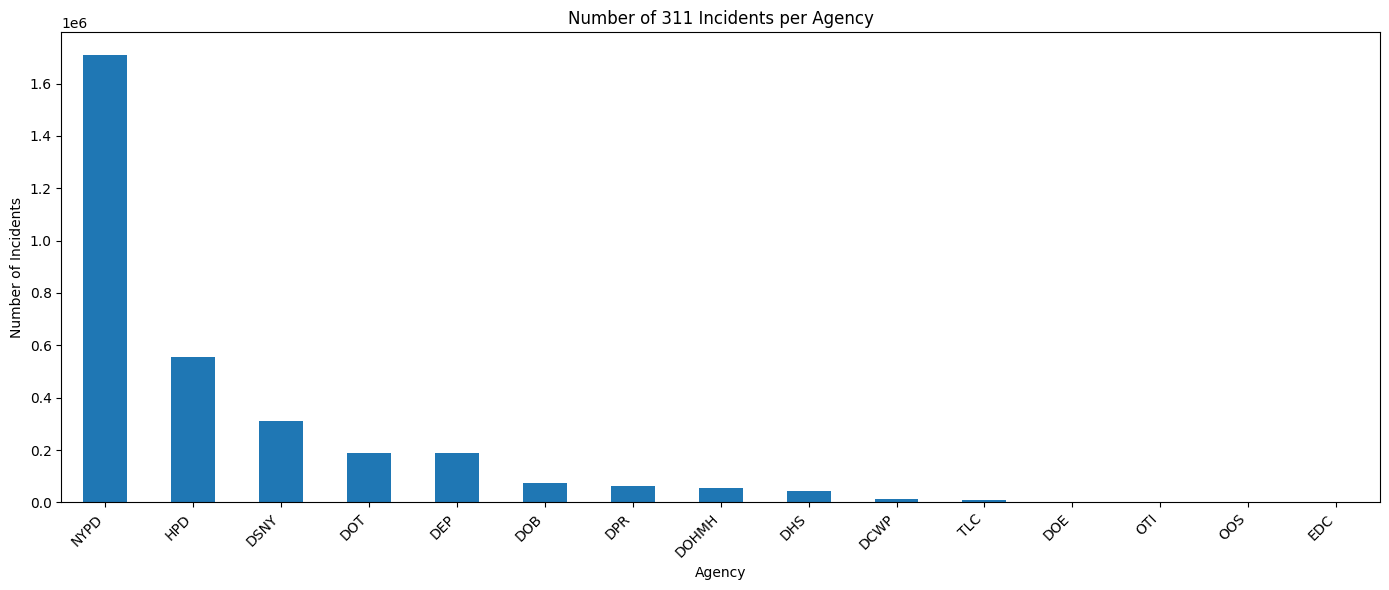

In [99]:
agency_counts = df2['agency'].value_counts()

plt.figure(figsize=(14, 6))
agency_counts.plot(kind='bar')
plt.title("Number of 311 Incidents per Agency")
plt.xlabel("Agency")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [100]:
agency_counts = df['agency'].value_counts()
total_incidents = agency_counts.sum()

agency_table = pd.DataFrame({
    "Agency": agency_counts.index,
    "Number of Incidents": agency_counts.values,
})

# Add percentage column
agency_table["Percentage"] = (agency_table["Number of Incidents"] / total_incidents) * 100

# Format number of incidents with commas
agency_table["Number of Incidents"] = agency_table["Number of Incidents"].map(lambda x: f"{x:,}")

# Format percentage to 2 decimal places
agency_table["Percentage"] = agency_table["Percentage"].map(lambda x: f"{x:.2f}%")

print("Top Agencies by Number of Incidents:\n")
print(agency_table.to_string(index=False))

Top Agencies by Number of Incidents:

Agency Number of Incidents Percentage
  NYPD           1,710,236     53.32%
   HPD             554,921     17.30%
  DSNY             310,102      9.67%
   DOT             189,489      5.91%
   DEP             187,732      5.85%
   DOB              73,574      2.29%
   DPR              62,877      1.96%
 DOHMH              53,127      1.66%
   DHS              42,782      1.33%
  DCWP              12,002      0.37%
   TLC               9,557      0.30%
   DOE                 681      0.02%
   OTI                 187      0.01%
   OOS                  67      0.00%
   EDC                   2      0.00%


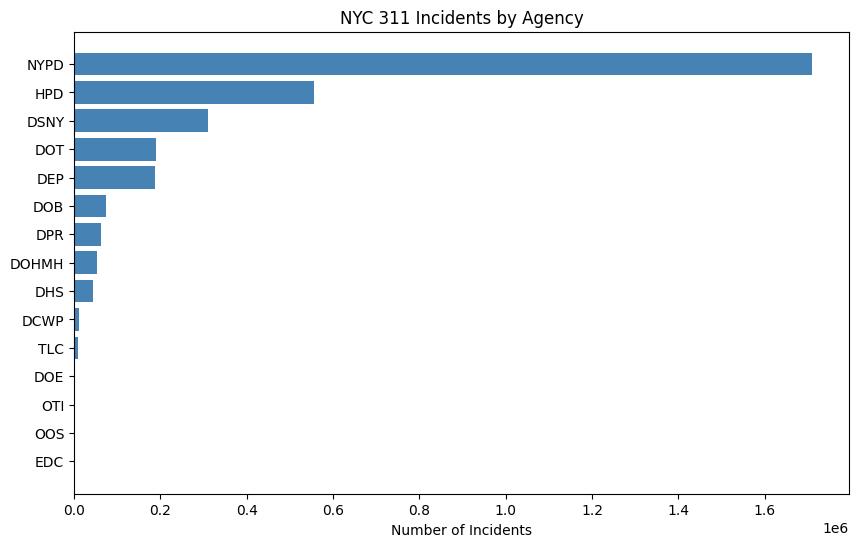

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(agency_table["Agency"], 
         agency_counts.values, 
         color='steelblue')
plt.xlabel("Number of Incidents")
plt.title("NYC 311 Incidents by Agency")
plt.gca().invert_yaxis()  # because value_counts is descending
plt.show()

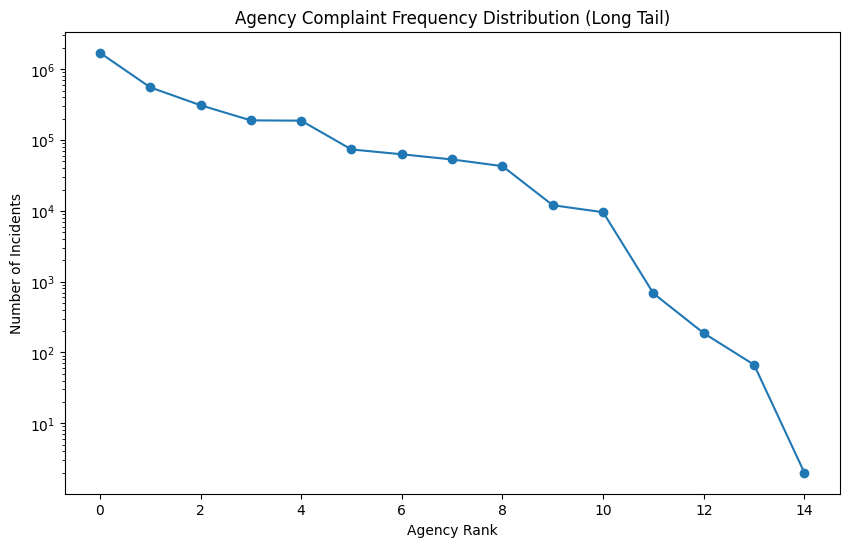

In [102]:
agency_counts_sorted = agency_counts.sort_values(ascending=False).reset_index()
agency_counts_sorted.columns = ["Agency", "Count"]

plt.figure(figsize=(10,6))
plt.plot(agency_counts_sorted["Count"], marker="o")
plt.title("Agency Complaint Frequency Distribution (Long Tail)")
plt.xlabel("Agency Rank")
plt.ylabel("Number of Incidents")
plt.yscale("log")  # shows exponential drop clearly
plt.show()

The distribution of complaints across agencies follows a classic long-tail pattern: a very small number of agencies ranking 0 to 4 (NYPD, HPD, DSNY, DOT, and DEP) account for more than 92% of all 311 incidents, while the remaining agencies each contribute less than 3% individually and, in many cases, less than 0.1%. This extreme imbalance means that 1) lower-volume agencies lack the statistical density required to support reliable modeling or pattern detection and 2) their sparse data introduces noise and increases variance without meaningfully improving predictive power. By limiting the dataset to the top five agencies, we retain almost all of the actionable signal while removing categories that contribute disproportionately to noise. This improves model consistency, reduces sparsity, and allows the model to predict more accurately.

In [127]:
df2["agency"].value_counts()

agency
NYPD     1710236
HPD       554921
DSNY      310102
DOT       189489
DEP       187732
DOB        73574
DPR        62877
DOHMH      53127
DHS        42782
DCWP       12002
TLC         9557
DOE          681
OTI          187
OOS           67
EDC            2
Name: count, dtype: int64

In [104]:
# Remove data for agencies outside the top 5
top_agencies = agency_counts.head(5).index
df3 = df2[df2['agency'].isin(top_agencies)].reset_index(drop=True)
df3.shape

(2952480, 12)

In [143]:
print("Remaining rows after filtering agencies:", len(df3))
df3["agency"].value_counts()

Remaining rows after filtering agencies: 2952480


agency
NYPD    1710236
HPD      554921
DSNY     310102
DOT      189489
DEP      187732
Name: count, dtype: int64

In [ ]:
agency_counts = df3["agency"].value_counts()
total_agency = agency_counts.sum()

agency_table = pd.DataFrame({
    "Agency": agency_counts.index,
    "Number of Incidents": agency_counts.values
})

agency_table["Percentage"] = (agency_table["Number of Incidents"] / total_agency) * 100

agency_table["Number of Incidents"] = agency_table["Number of Incidents"].map(lambda x: f"{x:,}")
agency_table["Percentage"] = agency_table["Percentage"].map(lambda x: f"{x:.2f}%")

print("\nAgency Distribution:\n")
print(agency_table.to_string(index=False))



Agency Distribution:

Agency Number of Incidents Percentage
  NYPD           1,710,236     57.93%
   HPD             554,921     18.80%
  DSNY             310,102     10.50%
   DOT             189,489      6.42%
   DEP             187,732      6.36%


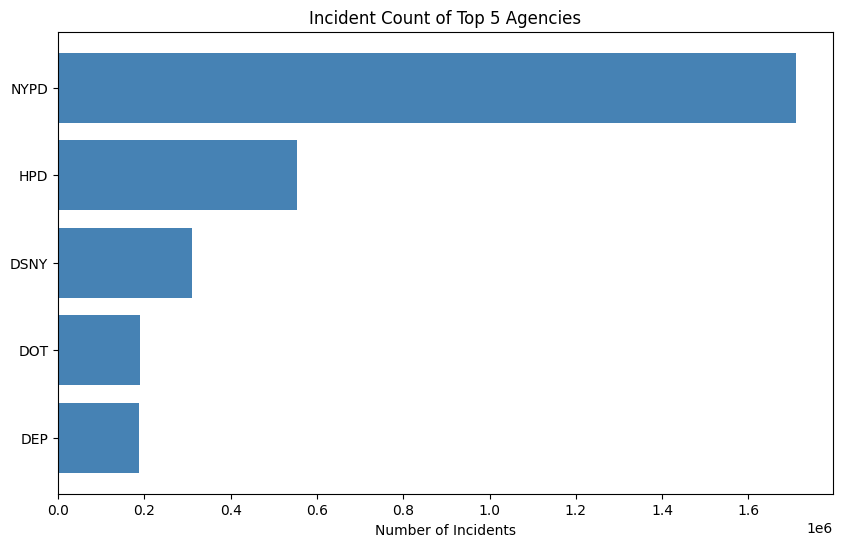

In [149]:
plt.figure(figsize=(10,6))
plt.barh(agency_counts.index, agency_counts.values, color="steelblue")
plt.xlabel("Number of Incidents")
plt.title("Incident Count of Top 5 Agencies")
plt.gca().invert_yaxis()
plt.show()

In [153]:
# Count boroughs
borough_counts = df3["borough"].value_counts()

# Compute total
total = borough_counts.sum()

# Build table
borough_table = pd.DataFrame({
    "Borough": borough_counts.index,
    "Number of Incidents": borough_counts.values,
})

total_borough = borough_counts.sum()

# Add percentage
borough_table["Percentage"] = (borough_table["Number of Incidents"] / total) * 100

# Format
borough_table["Number of Incidents"] = borough_table["Number of Incidents"].map(lambda x: f"{x:,}")
borough_table["Percentage"] = borough_table["Percentage"].map(lambda x: f"{x:.2f}%")

print("\nBorough Distribution:\n")
print(borough_table.to_string(index=False))


Borough Distribution:

      Borough Number of Incidents Percentage
     BROOKLYN             878,785     29.76%
       QUEENS             722,482     24.47%
        BRONX             712,280     24.12%
    MANHATTAN             531,777     18.01%
STATEN ISLAND             105,818      3.58%
  Unspecified               1,338      0.05%


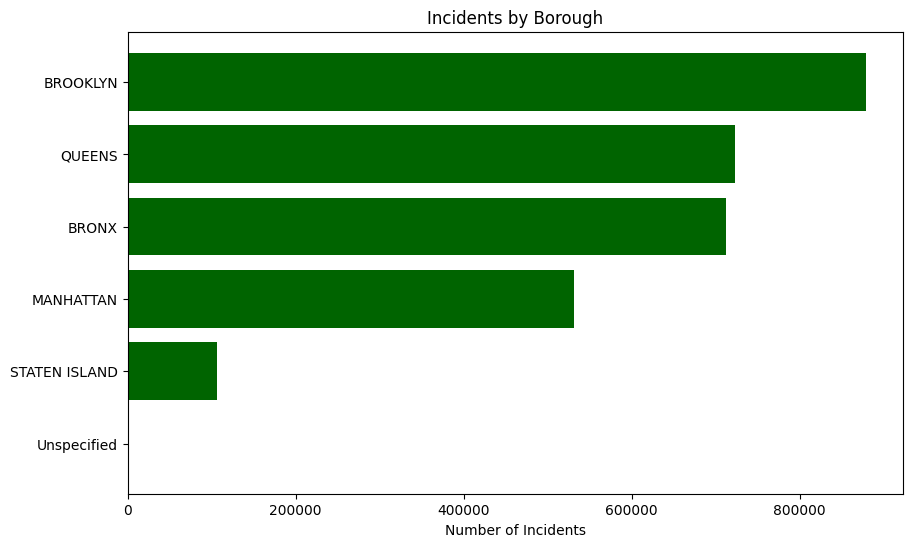

In [141]:
plt.figure(figsize=(10,6))
plt.barh(borough_counts.index, borough_counts.values, color='darkgreen')
plt.xlabel("Number of Incidents")
plt.title("Incidents by Borough")
plt.gca().invert_yaxis()
plt.show()

In [154]:
threshold = 0.05  # 5%
valid_boroughs = borough_counts[borough_counts / total_borough >= threshold].index.tolist()

print("Boroughs kept:", valid_boroughs)

Boroughs kept: ['BROOKLYN', 'QUEENS', 'BRONX', 'MANHATTAN']


In [158]:
# Create df4 by dropping Staten Island and Unspecified boroughs
df4 = df3[~df3["borough"].isin(["STATEN ISLAND", "Unspecified"])].copy()

print("Rows before:", len(df3))
print("Rows after :", len(df4))

Rows before: 2952480
Rows after : 2845324


In [160]:
# Borough counts from df4
borough_counts = df4["borough"].value_counts()
total_borough = borough_counts.sum()

borough_table = pd.DataFrame({
    "Borough": borough_counts.index,
    "Number of Incidents": borough_counts.values
})

# Percentage column
borough_table["Percentage"] = (borough_table["Number of Incidents"] / total_borough) * 100

# Formatting
borough_table["Number of Incidents"] = borough_table["Number of Incidents"].map(lambda x: f"{x:,}")
borough_table["Percentage"] = borough_table["Percentage"].map(lambda x: f"{x:.2f}%")

print("\nBorough Distribution:\n")
print(borough_table.to_string(index=False))



Borough Distribution:

  Borough Number of Incidents Percentage
 BROOKLYN             878,785     30.89%
   QUEENS             722,482     25.39%
    BRONX             712,280     25.03%
MANHATTAN             531,777     18.69%


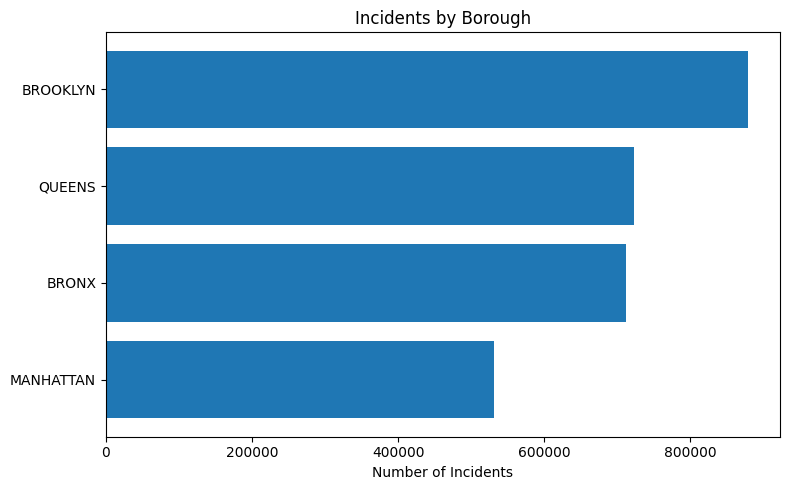

In [163]:
plt.figure(figsize=(8, 5))
plt.barh(borough_counts.index, borough_counts.values)
plt.xlabel("Number of Incidents")
plt.title("Incidents by Borough")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Removal of Staten Island and "Unspecified" borough

After filtering the dataset to include only the top five agencies with meaningful sample sizes, we examined borough distribution within this reduced dataset. At this stage, Staten Island and “Unspecified” borough entries accounted for a very small fraction of total incidents, which were far below the threshold needed to provide statistically reliable patterns. 
Including boroughs with extremely low sample sizes introduces instability into downstream modeling, especially for tasks such as predicting incident volume or estimating resolution time, where adequate representation is required for the model to learn meaningful trends. 
Additionally, “Unspecified” records do not contain actionable geographic information and therefore cannot contribute to spatial or operational insights. For these reasons, both categories were removed to ensure the model is trained on data that is sufficiently robust, interpretable, and operationally relevant.

### Removal of agencies and boroughs

The same guiding principle was applied consistently throughout our data refinement process: retain only categories with a large enough sample size to support stable modeling and meaningful interpretation. 
For agencies, data volume was heavily skewed, with only a handful of departments responsible for more than 90% of all incidents. Keeping only these high-volume agencies reduced noise and sharpened the model’s ability to learn operational patterns. When applying this principle to boroughs, the distribution was less extreme, but the same logic held—categories with insufficient representation (Staten Island and “Unspecified”) were removed because they could not provide reliable signals for modeling or evaluation. 
This approach ensures that the final dataset is both analytically strong and aligned with the real-world operational focus of NYC 311 services.

## Analysis of resolution time by boroughs/agencies

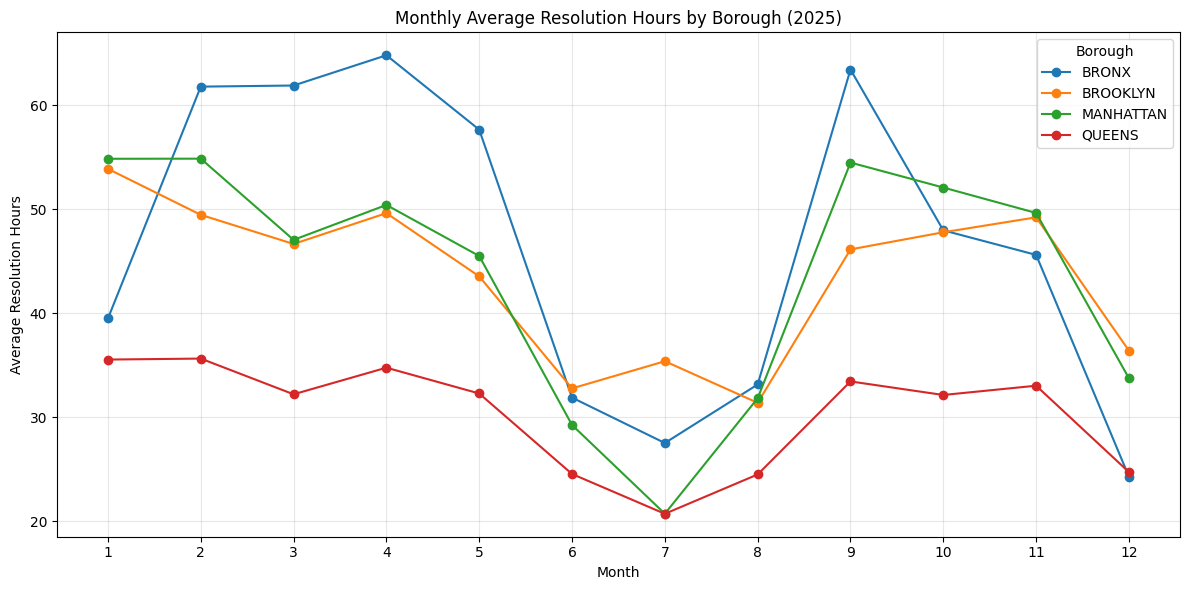

In [165]:
# Group by borough + month
borough_monthly = (
    df4.groupby(["borough", "month"])["resolution_hours"]
       .mean()
       .reset_index()
)

plt.figure(figsize=(12, 6))

for borough in borough_monthly["borough"].unique():
    subset = borough_monthly[borough_monthly["borough"] == borough]
    plt.plot(subset["month"], subset["resolution_hours"], marker='o', label=borough)

plt.title("Monthly Average Resolution Hours by Borough (2025)")
plt.xlabel("Month")
plt.ylabel("Average Resolution Hours")
plt.xticks(range(1, 13))
plt.legend(title="Borough")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


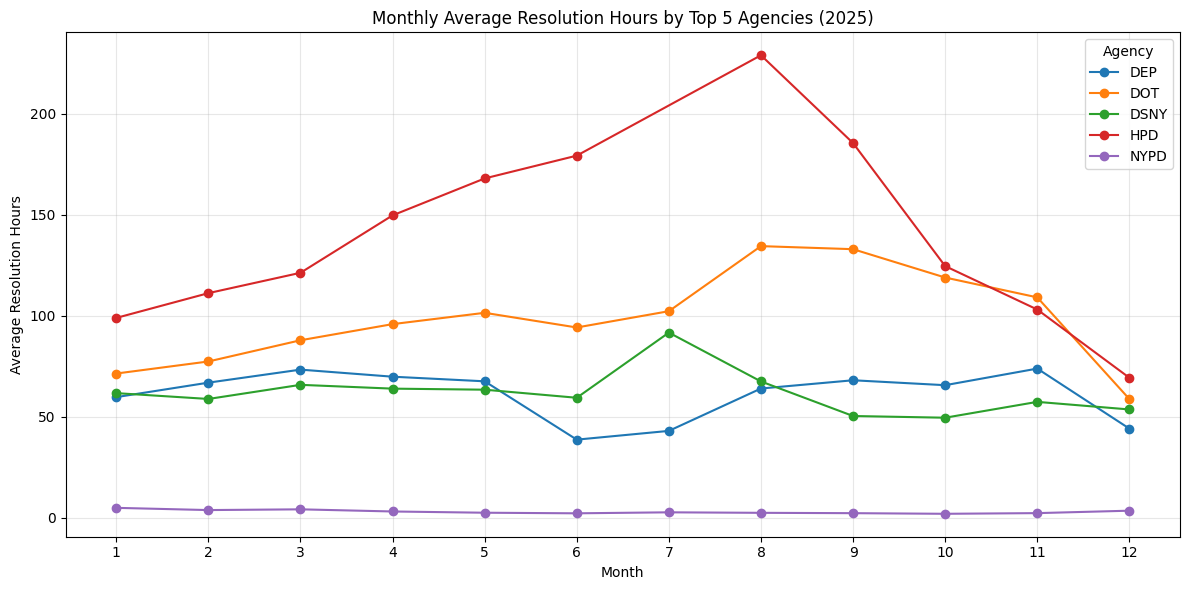

In [166]:
top_agencies = ["NYPD", "HPD", "DSNY", "DOT", "DEP"]

agency_monthly = (
    df4[df4["agency"].isin(top_agencies)]
    .groupby(["agency", "month"])["resolution_hours"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 6))

for agency in agency_monthly["agency"].unique():
    subset = agency_monthly[agency_monthly["agency"] == agency]
    plt.plot(subset["month"], subset["resolution_hours"], marker='o', label=agency)

plt.title("Monthly Average Resolution Hours by Top 5 Agencies (2025)")
plt.xlabel("Month")
plt.ylabel("Average Resolution Hours")
plt.xticks(range(1, 13))
plt.legend(title="Agency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


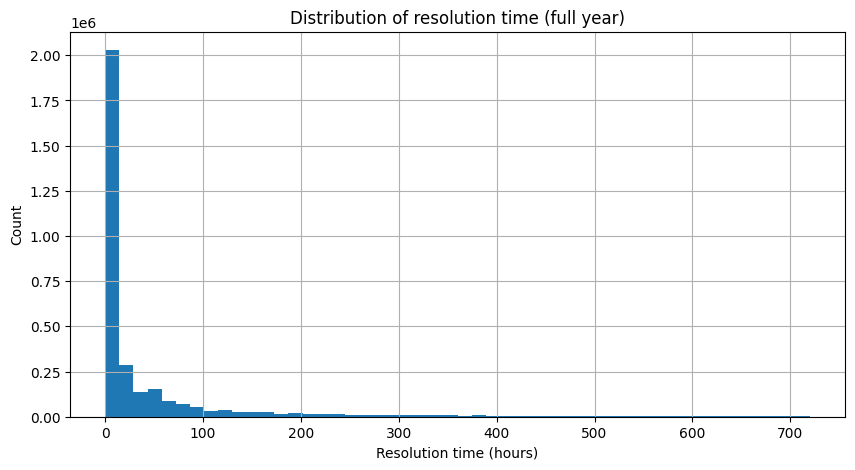

In [110]:
df["resolution_hours"].describe()
df["resolution_hours"].hist(bins=50)
plt.xlabel("Resolution time (hours)")
plt.ylabel("Count")
plt.title("Distribution of resolution time (full year)")
plt.show()

In [111]:
# Do quartiles - show as a box plot 

In [112]:
# Top complaint types and agencies
top_complaints = df["complaint_type"].value_counts().head(30).index
top_agencies = df["agency"].value_counts().head(20).index

df_model = df[
    df["complaint_type"].isin(top_complaints)
    & df["agency"].isin(top_agencies)
].copy()

df_model.shape

(2725841, 14)

In [113]:
n_sample = min(300_000, len(df_model))
df_sample = df_model.sample(n=n_sample, random_state=42)
df_sample.shape

(300000, 14)

In [114]:
target_col = "resolution_hours"

feature_cols = [
    "complaint_type",
    "borough",
    "agency",
    "month",
    "hour",
    "weekday",
    "is_weekend",
]

df_sample = df_sample.dropna(subset=feature_cols + [target_col]).copy()

X_raw = df_sample[feature_cols]
y = df_sample[target_col]

X_raw.head()


,complaint_type,borough,agency,month,hour,weekday,is_weekend
33746,Illegal Parking,QUEENS,NYPD,12.0,22.0,0.0,0.0
2096744,Water System,BROOKLYN,DEP,8.0,17.0,3.0,0.0
1627346,Water System,QUEENS,DEP,7.0,7.0,1.0,0.0
992057,Water System,BROOKLYN,DEP,4.0,14.0,4.0,0.0
995086,Noise - Residential,BRONX,NYPD,4.0,21.0,4.0,0.0


In [115]:
categorical_cols = ["complaint_type", "borough", "agency"]
numeric_cols = ["month", "hour", "weekday", "is_weekend"]

X_categorical = pd.get_dummies(X_raw[categorical_cols], drop_first=True)
X_numeric = X_raw[numeric_cols]

X = pd.concat([X_numeric, X_categorical], axis=1)

X.shape, y.shape

((300000, 45), (300000,))

In [116]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=153
)

X_train.shape, X_test.shape

((240000, 45), (60000, 45))

In [117]:
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)
base_mae = mean_absolute_error(y_test, y_pred_base)
base_r2 = r2_score(y_test, y_pred_base)

base_mae, base_r2

(45.86480712890625, -4.303455352783203e-05)

In [118]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

lr_mae, lr_r2

(29.474184036254883, 0.36729997396469116)

In [119]:
rf = RandomForestRegressor(
    n_estimators=150,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

rf_mae, rf_r2

(26.48463048206785, 0.33925852804069245)

In [120]:
results = pd.DataFrame({
    "model": ["Baseline (mean)", "Linear Regression", "Random Forest"],
    "MAE_hours": [base_mae, lr_mae, rf_mae],
    "R2": [base_r2, lr_r2, rf_r2],
})
results

,model,MAE_hours,R2
0,Baseline (mean),45.864807,-0.000043
1,Linear Regression,29.474184,0.367300
2,Random Forest,26.484630,0.339259


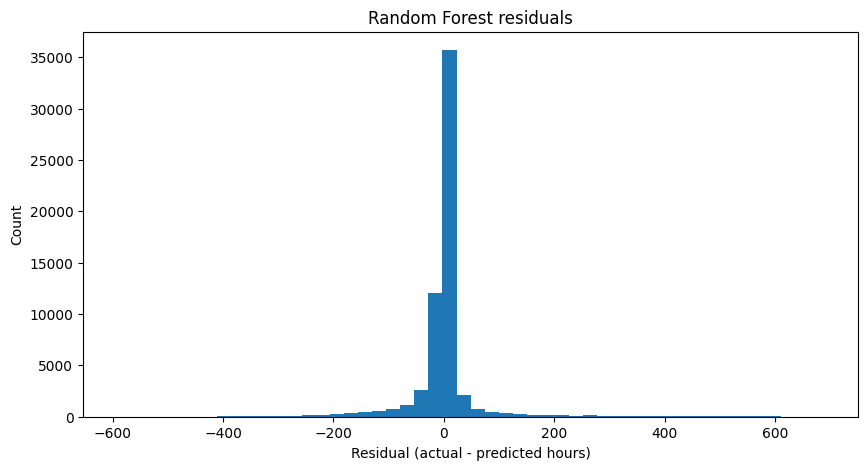

Residual mean: -1.2246979089089347
Residual std: 70.0081529863498


In [121]:
residuals = y_test - y_pred_rf

plt.hist(residuals, bins=50)
plt.xlabel("Residual (actual - predicted hours)")
plt.ylabel("Count")
plt.title("Random Forest residuals")
plt.show()

print("Residual mean:", residuals.mean())
print("Residual std:", residuals.std())

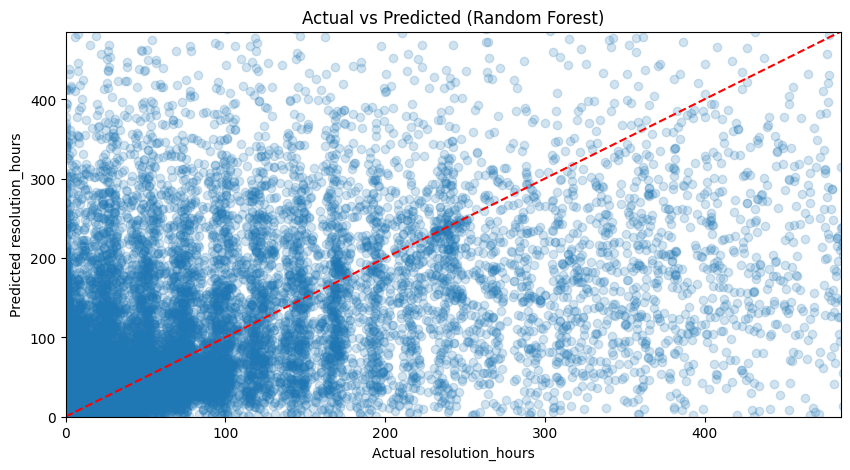

In [122]:
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.xlabel("Actual resolution_hours")
plt.ylabel("Predicted resolution_hours")
plt.title("Actual vs Predicted (Random Forest)")
plt.plot([0, y_test.max()], [0, y_test.max()], "r--")
plt.xlim(0, y_test.quantile(0.99))
plt.ylim(0, y_test.quantile(0.99))
plt.show()

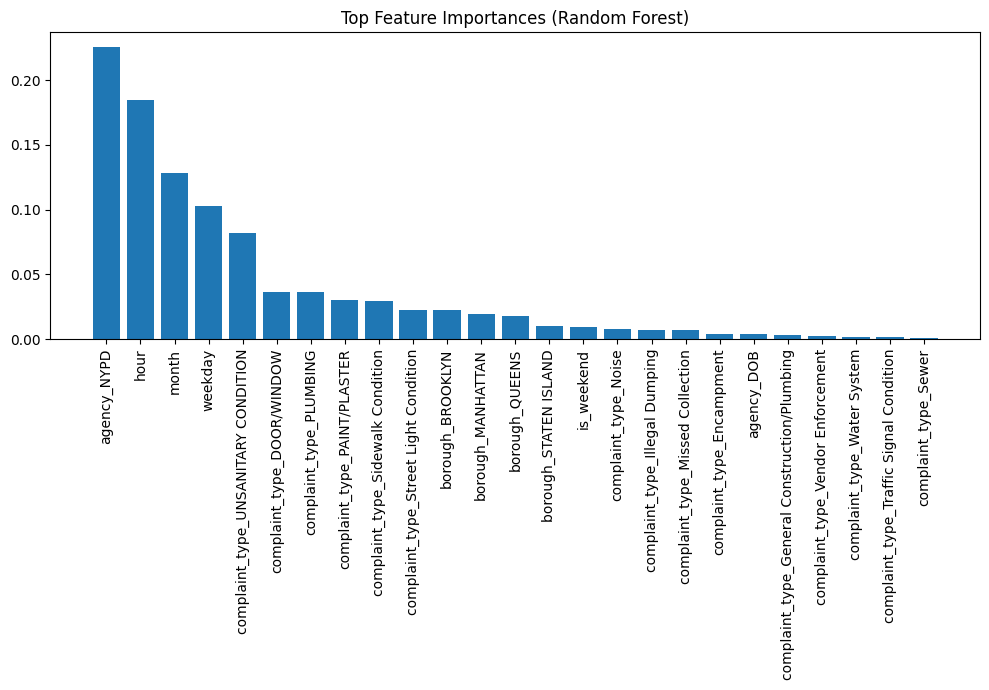

In [123]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

top_n = 25
top_idx = indices[:top_n]

plt.figure(figsize=(10, 7))
plt.bar(range(top_n), importances[top_idx])
plt.xticks(range(top_n), feature_names[top_idx], rotation=90)
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()